## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 3
### Prowadzący: Michał Kempka
### Autor: Jakub Frąszczak 136704

## Wprowadzenie do Zadania 1

Zadanie będzie polegało na implementacji algorytmu Deep Deterministic Policy Gradient (DDPG) dla środowiska `LunarLanderContinuous` z biblioteki OpenAI Gym (https://gym.openai.com).

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [1]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy box2d
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

     |████████████████████████████████| 1.3MB 13.0MB/s 


In [2]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gym

env = gym.make("LunarLanderContinuous-v2")

observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    if done:
        observation = env.reset()
env.close()

NoSuchDisplayException: ignored

In [ ]:
# `LunarLanderContinuous` to wersja środowiska `LunarLander` z ciągłymi akcjami
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji w obu wersjach:
env_dis = gym.make("LunarLander-v2")
env_con = gym.make("LunarLanderContinuous-v2")

print("Przestrzeń stanów:", env_dis.observation_space, env_con.observation_space)
print("Rozmiar wektora reprezntującego stany:", env_dis.observation_space.shape, env_con.observation_space.shape)
print("Przestrzeń akcji:", env_dis.action_space, env_con.action_space)
# Jak widać, przestrzeń akcji zmieniła się z dyskretnej o wielkości 4 na wektor 2 liczb z zakresu od -1 do 1

Przestrzeń stanów: Box(-inf, inf, (8,), float32) Box(-inf, inf, (8,), float32)
Rozmiar wektora reprezntującego stany: (8,) (8,)
Przestrzeń akcji: Discrete(4) Box(-1.0, 1.0, (2,), float32)


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej (identyczna jak w `homework-2-qlearning.ipynb`). Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziesz też funkcję `run_agent_in_env` (również jest taka sama jak w `homework-2-qlearning.ipynb`), która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [3]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [4]:
from collections import deque
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    plt.plot(rewards)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
    rewards = []
    last_rewards = deque(maxlen=30)
    rewards_to_plot = []
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done:
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation

        last_rewards.append(total_reward)
        rewards.append(total_reward)
        rewards_to_plot.append(sum(last_rewards) / len(last_rewards))
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards_to_plot)
    return rewards     

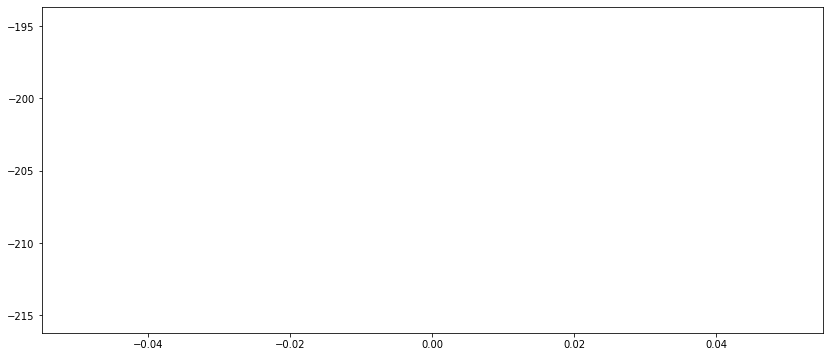

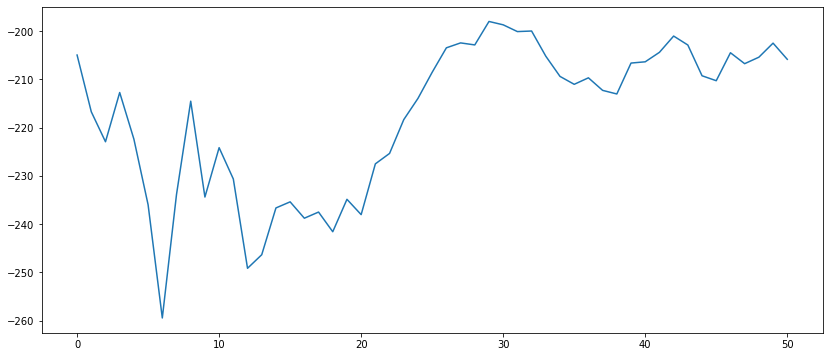

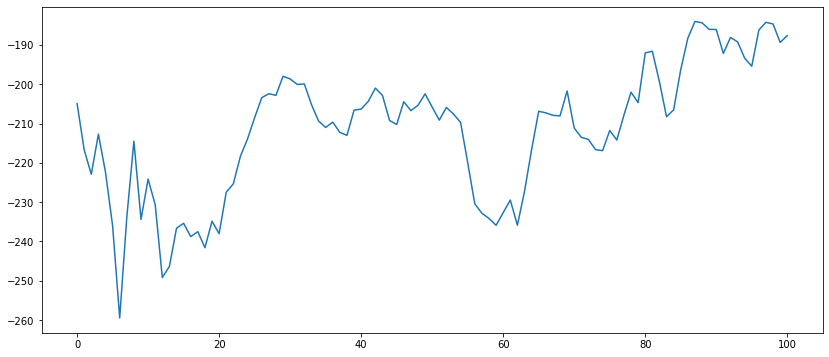

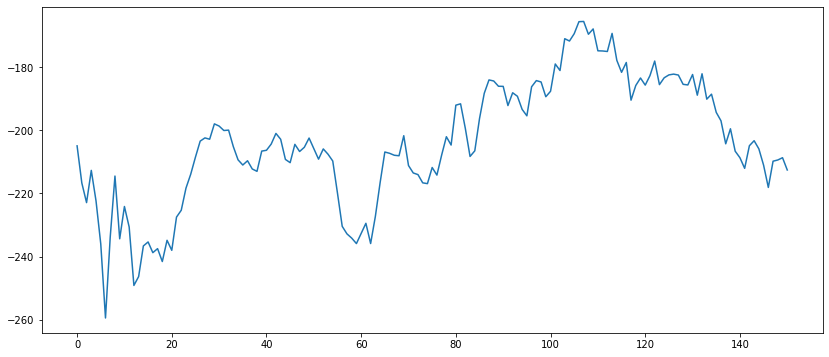

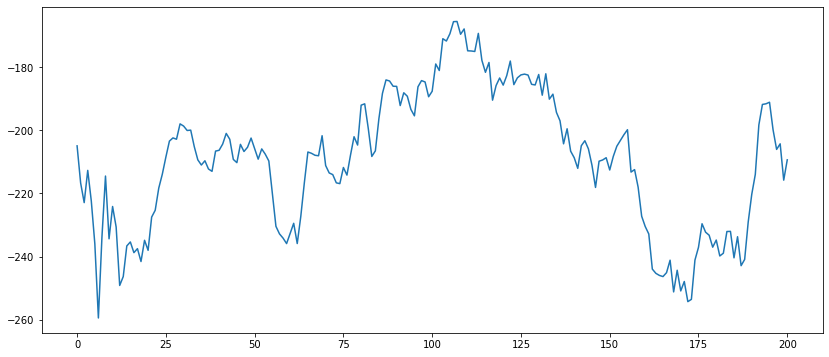

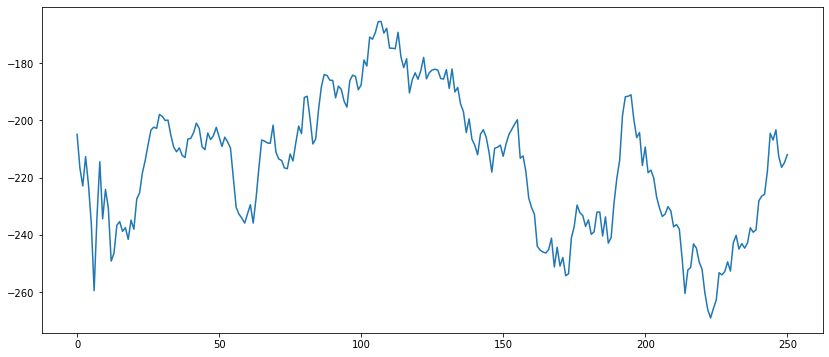

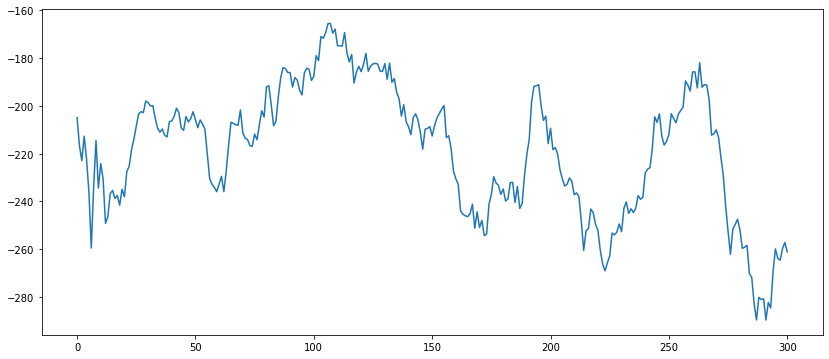

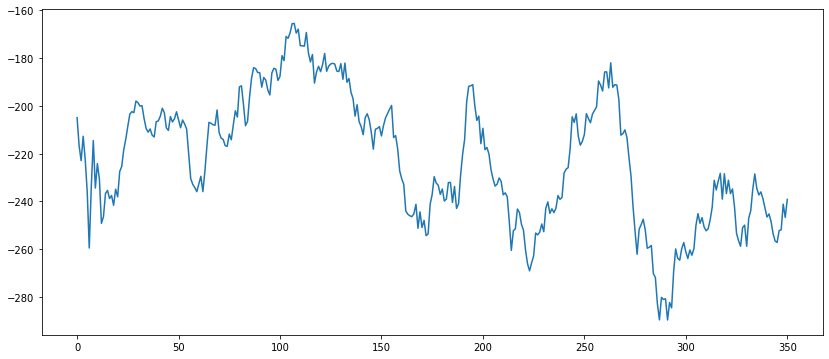

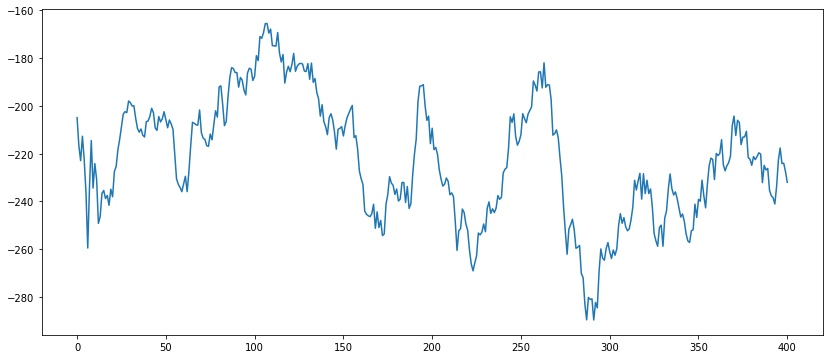

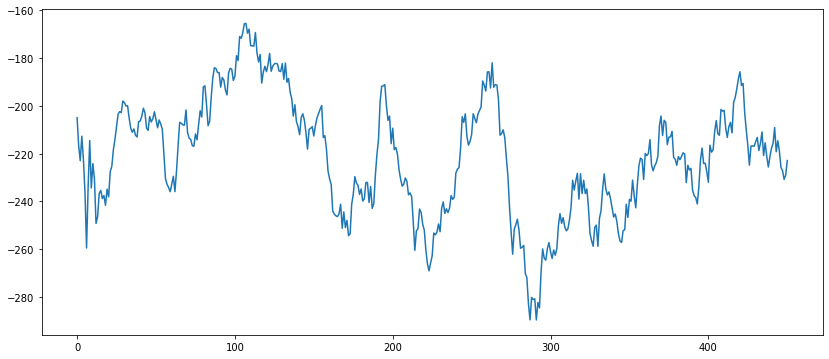

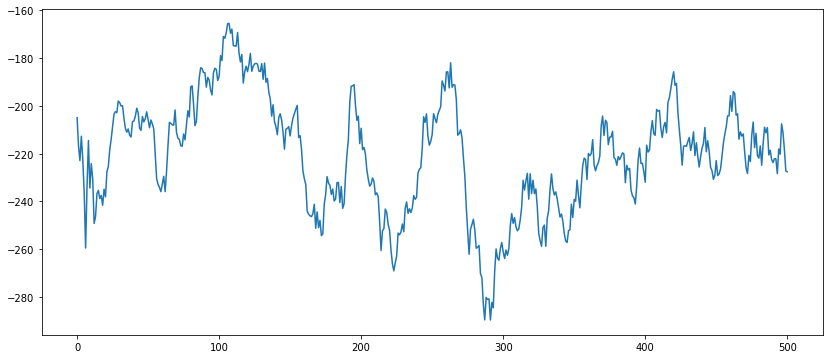

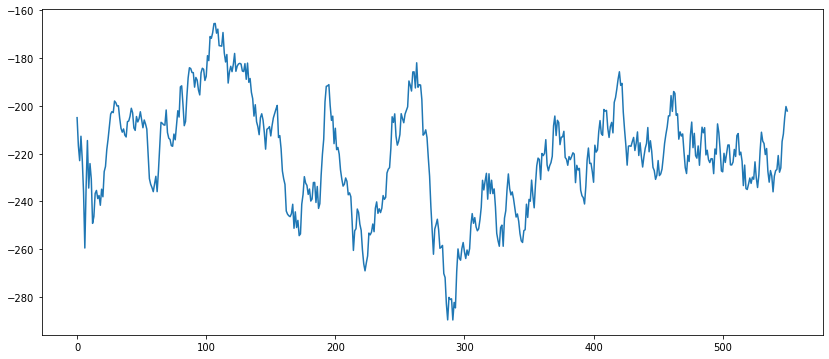

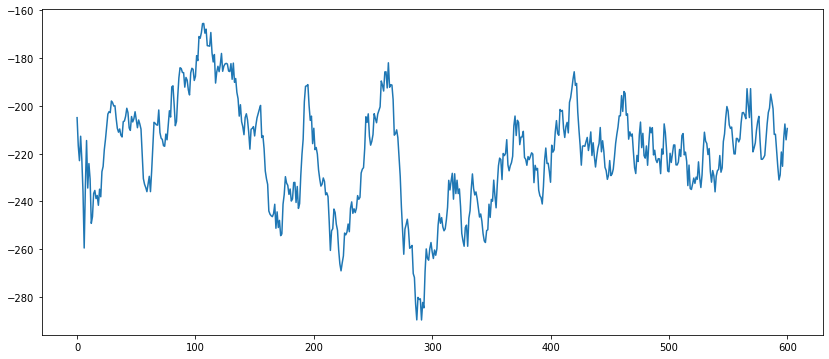

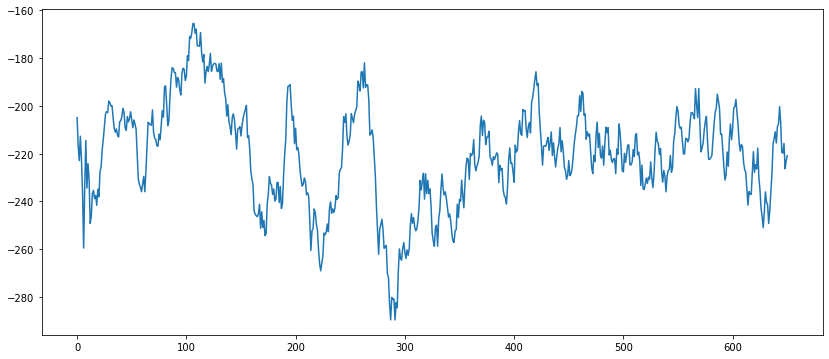

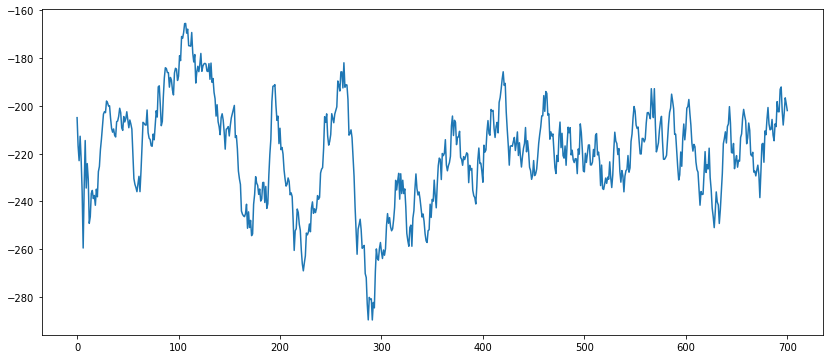

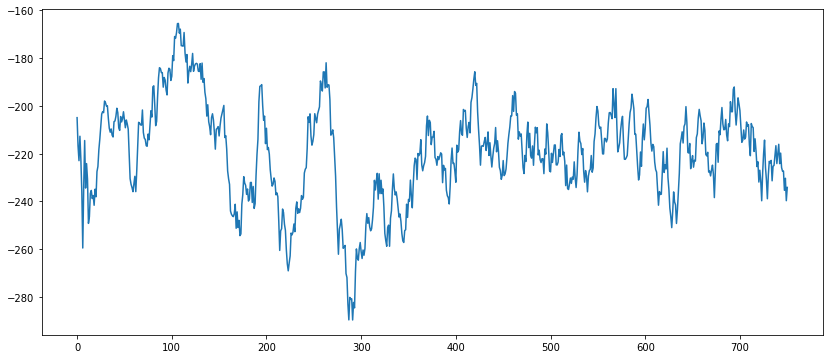

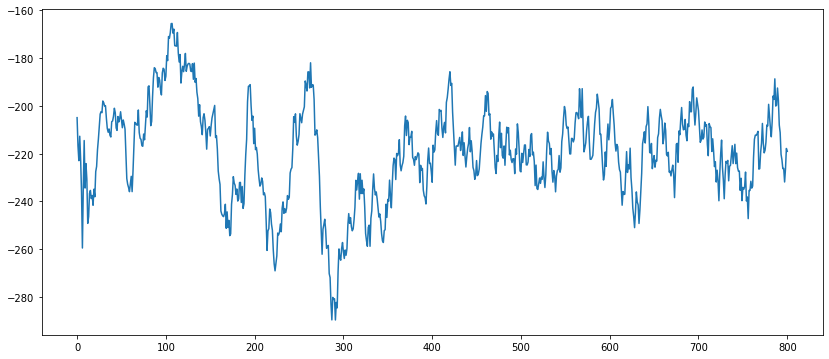

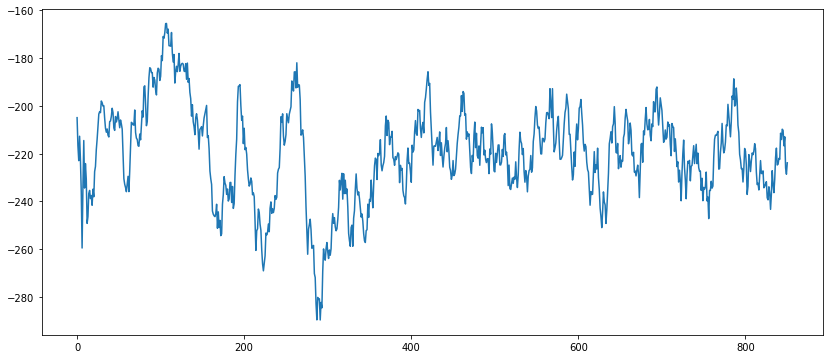

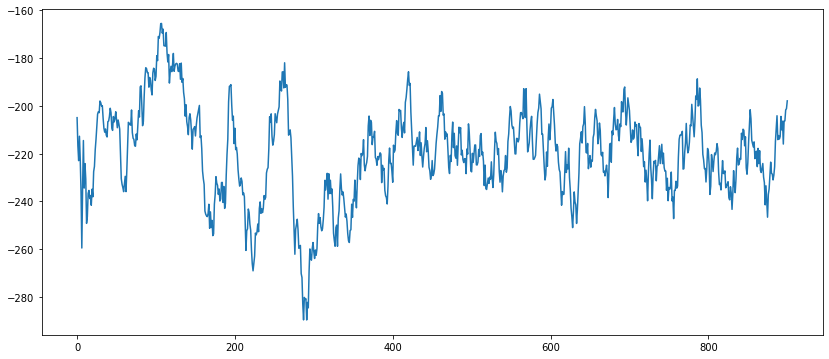

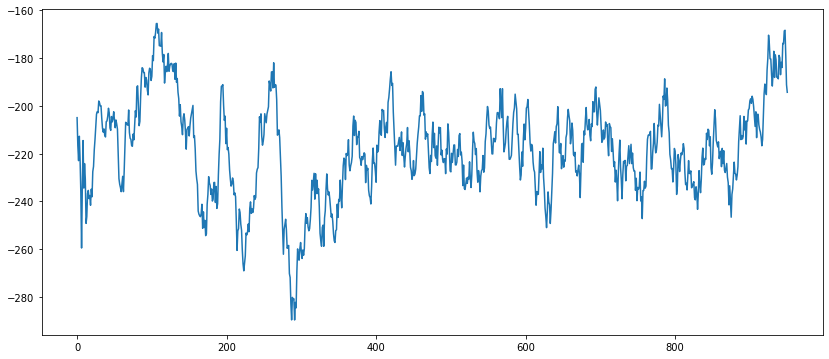

In [5]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("LunarLanderContinuous-v2")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    
    def process_transition(self, observation, action, reward, next_observation, done):
        pass
        
    def get_action(self, observation, learning):
        return self.action_space.sample()
    
random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

## Zad 1 - Deep Deterministic Policy Gradient (10pkt)

W komórkach poniżej zaimplementuj Deep Deterministic Policy Gradient dla środowiska `LunarLanderContinuous` z eksploracją opartą o dodawanie szumu Gaussowskiego, a jako aproksymatorów użyj prostych sieci neuronowych zaimplementowanych z wykorzystaniem biblioteki PyTroch.

Uwagi:
- Dobra polityka powina mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj by domyślnie Twoja implemnetacja działałą na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architektuę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.

#### Uwaga: nie zmieniaj nazwy klasy `DDPGAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from collections import deque
import random


class ActorNetwork(nn.Module):
  def __init__(self, state_dim, action_dim, hidden_size=256):
    super(ActorNetwork, self).__init__()
    self.linear1 = nn.Linear(state_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, action_dim)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
  
  def forward(self, state):
    out = self.linear1(state)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    out = self.tanh(out)
    return out


class CriticNetwork(nn.Module):
  def __init__(self, state_dim, action_dim, hidden_size=256):
    super(CriticNetwork, self).__init__()
    self.linear1 = nn.Linear(state_dim + action_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, state, action):
    input = torch.cat([state, action], 1)
    out = self.linear1(input)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    return out
        
class DDPGAgent(Agent):
    def __init__(self, env):
      super().__init__(env)

      self.state_dim = env.observation_space.shape[0]
      self.action_dim = env.action_space.shape[0]

      self.actor_lr = 1e-4
      self.critic_lr = 1e-3

      self.tau = 0.01
      self.batch_size = 128
      self.replay_frequency = 8
      self.memory = deque(maxlen=5000)
      self.gamma = 0.99 
      self.noise_std = 0.2

      self.actor = ActorNetwork(self.state_dim, self.action_dim)
      self.actor_target = ActorNetwork(self.state_dim, self.action_dim)
      self.actor_optimiser  = Adam(self.actor.parameters(), lr=self.actor_lr)

      self.critic = CriticNetwork(self.state_dim, self.action_dim)
      self.critic_target = CriticNetwork(self.state_dim, self.action_dim)
      self.critic_optimiser  = Adam(self.critic.parameters(), lr=self.critic_lr)

      self.loss = nn.MSELoss()          
      self.iterations = 0
        
    def gaussian_noise(self):
      return np.random.normal(loc=0.0, scale=self.noise_std, size=self.action_dim) 

    def soft_update(self, model, model_target):
      for target_param, local_param in zip(model_target.parameters(), model.parameters()):
          target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
                
    def update_target_networks(self):
      self.soft_update(self.actor, self.actor_target)
      self.soft_update(self.critic, self.critic_target)

    def process_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.iterations += 1

        if self.iterations == self.replay_frequency:
          self.replay()
          self.iterations = 0

        self.update_target_networks()   
        
    def to_tensor(self, ndarray, volatile=False, requires_grad=False, dtype=torch.FloatTensor):
      return Variable(torch.from_numpy(ndarray), volatile=volatile, requires_grad=requires_grad).type(dtype)

    def get_action(self, state, learning):
      action = self.actor(self.to_tensor(np.array([state]))).data.numpy().squeeze(0)
      if learning:
        action += self.gaussian_noise()
        action = np.clip(action, -1., 1.)
      return action

    def calculate_target_q_value(self, state, action, reward, next_state, done):
      if done:
        return reward

      next_state = np.array([next_state])
      next_state = self.to_tensor(next_state, volatile = True)
      actor_action = self.actor_target(next_state)
      q_next = self.critic_target(next_state, actor_action).item()
      q = reward + self.gamma * q_next

      return q
    
    def critic_update(self, q_values_batch, target_q_values_batch):
      self.critic.zero_grad()
      loss = self.loss(q_values_batch, target_q_values_batch)
      loss.backward()
      self.critic_optimiser.step()

    def actor_update(self, states_batch, actor_actions_batch):
      self.actor.zero_grad()
      loss = -self.critic(states_batch, actor_actions_batch).mean()
      loss.backward()
      self.actor_optimiser.step()

    def replay(self):
      states_batch = []
      actions_batch = []
      target_q_values_batch = []

      batch = random.sample(self.memory, min(self.batch_size, len(self.memory)))

      for state, action, reward, next_state, done in batch:
        q = self.calculate_target_q_value(state, action, reward, next_state, done)

        states_batch.append(state)
        actions_batch.append(action)
        target_q_values_batch.append(q)

      states_batch = np.asarray(states_batch)
      actions_batch = np.asarray(actions_batch)
      states_batch = self.to_tensor(states_batch)
      actions_batch = self.to_tensor(actions_batch)

      target_q_values_batch = np.asarray(target_q_values_batch)
      target_q_values_batch = np.expand_dims(target_q_values_batch, axis=1)
      target_q_values_batch = self.to_tensor(target_q_values_batch, volatile = True)

      q_values_batch = self.critic(states_batch, actions_batch)
      actor_actions_batch = self.actor(states_batch)

      self.critic_update(q_values_batch, target_q_values_batch)
      self.actor_update(states_batch, actor_actions_batch)
      

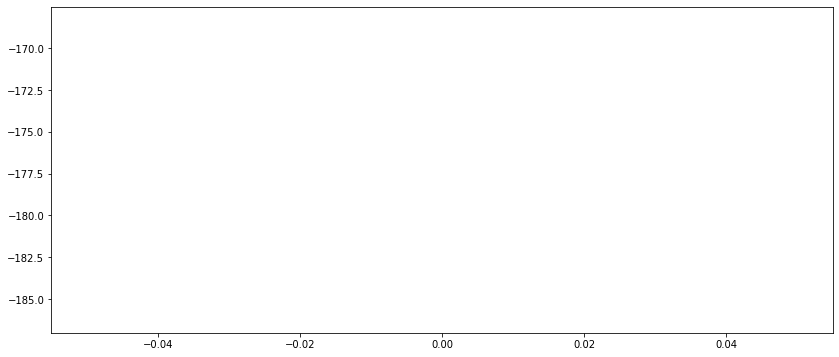

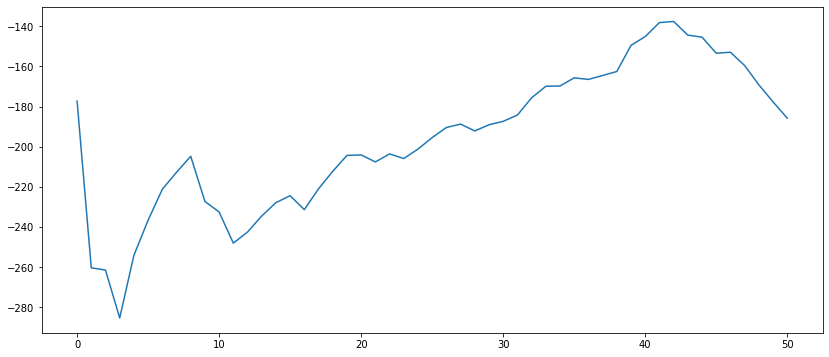

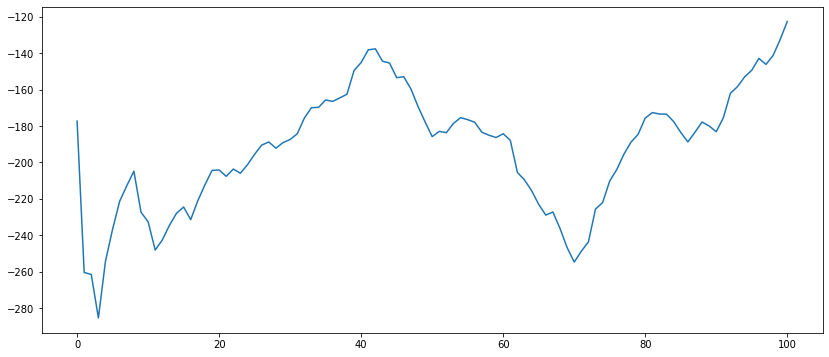

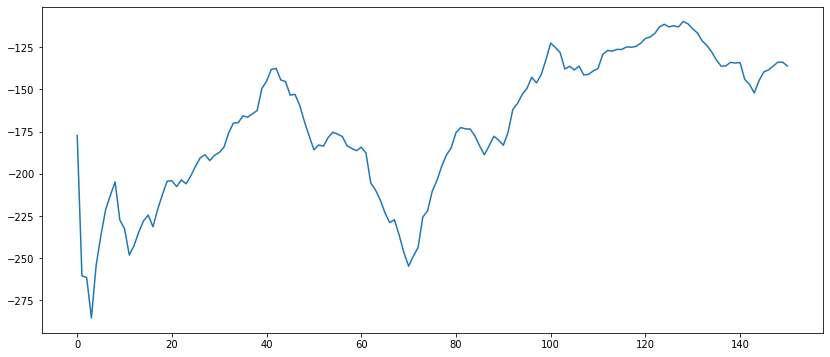

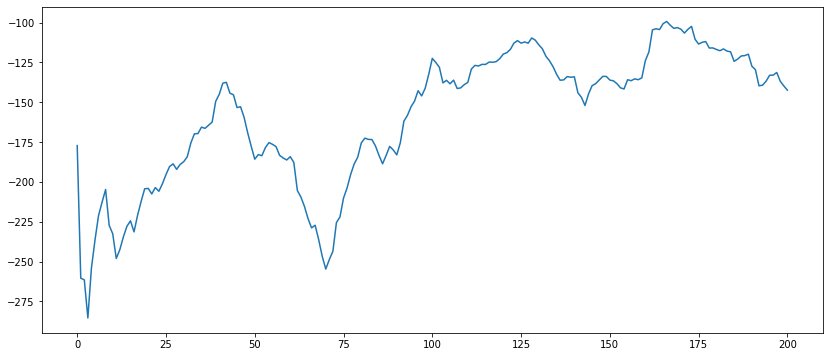

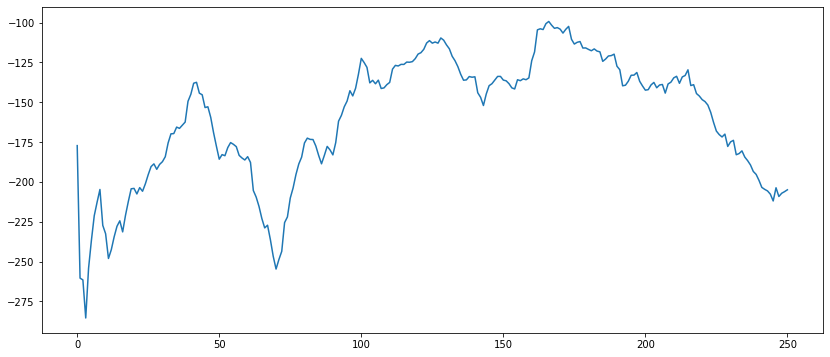

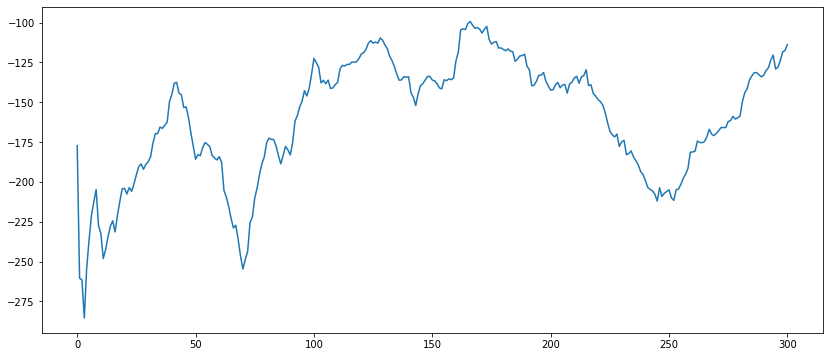

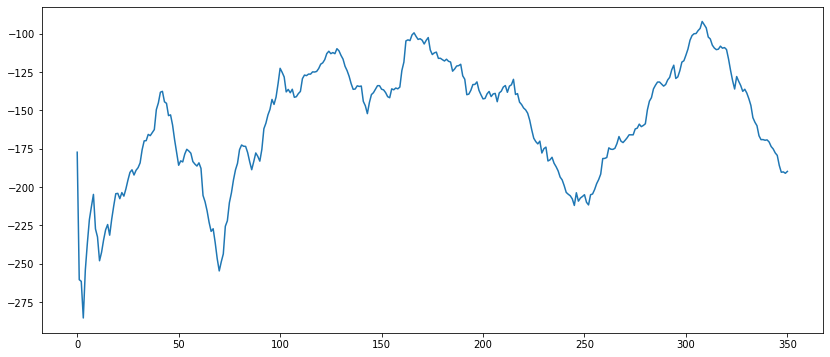

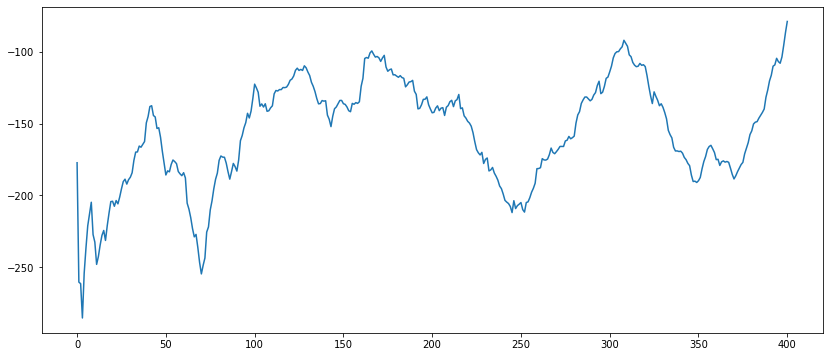

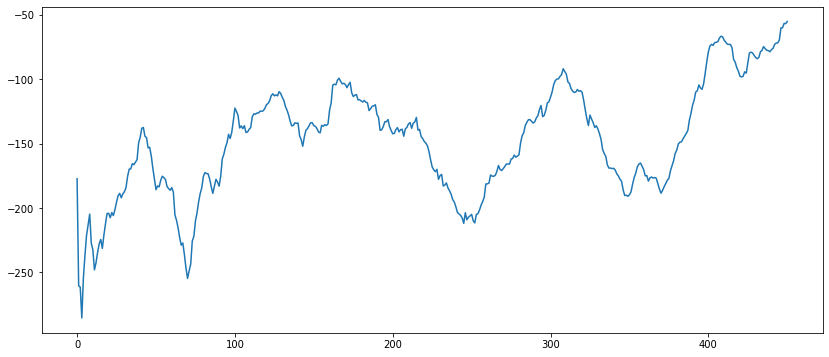

In [30]:
# Uczenie/testowania agenta
env = gym.make("LunarLanderContinuous-v2")
agent = DDPGAgent(env)
rewards = run_agent_in_env(env, agent, 3000, learning=True, plot=True, plot_interval=50)

In [31]:
rewards = run_agent_in_env(env, agent, 100, learning=False, plot=False)
print('Średni wynik')
print(sum(rewards) / len(rewards))

Średni wynik
-106.07627915467285


## Wprowadzenie do Zadania 2

Zadanie będzie polegało na implementacji algorytmu Monte Carlo Tree Search (MCTS) dla środowiska `Connect Four` z biblioteki DeepMind OpenSpiel (https://github.com/deepmind/open_spiel).

In [33]:
# Zainstaluj bibliotekę DeepMind OpenSpiel (tylko Linux i MacOS)
!pip install open_spiel

     |████████████████████████████████| 3.0MB 13.9MB/s 
     |████████████████████████████████| 1.6MB 34.2MB/s 
     |████████████████████████████████| 133kB 39.0MB/s 
     |████████████████████████████████| 394.3MB 36kB/s 
     |████████████████████████████████| 768kB 32.3MB/s 
     |████████████████████████████████| 983kB 20.7MB/s 
     |████████████████████████████████| 11.7MB 273kB/s 
     |████████████████████████████████| 1.6MB 43.4MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 522kB 27.3MB/s 
     |████████████████████████████████| 33.3MB 94kB/s 
     |████████████████████████████████| 266kB 52.1MB/s 
     |████████████████████████████████| 348kB 51.3MB/s 
     |████████████████████████████████| 776.8MB 16kB/s 
     |████████████████████████████████| 471kB 49.3MB/s 
     |████████████████████████████████| 3.8MB 25.1MB/s 
     |████████████████████████████████| 2.9MB 25.5MB/

### Środowisko `Connect Four`

Poniższy kod demonstruje działanie środowiska `Connect Four` (https://en.wikipedia.org/wiki/Connect_Four), gry dla dwóch graczy, deterministycznej z pełną informacją.

In [34]:
# Zobacz jak działają środowisko na przykładzie jednej gry
import random
import pyspiel
import numpy as np

game = pyspiel.load_game("connect_four")
state = game.new_initial_state()

while not state.is_terminal():
    print('Tura gracza:', state.current_player())
    print('Ruch:', state.move_number())
    print('Stan:'),
    print(state.observation_string())
    print('Dopuszczalne akcje:', state.legal_actions())
    a = np.random.choice(state.legal_actions()) # Wybieramy losową z dopuszczalnych akcji
    print('Wybrana akcja:', a)
    state.apply_action(a) # Stosujemy akcję
    print('-------')
print('Koniec gry, wyniki:', state.player_reward(0), ':', state.player_reward(1)) # albo state.rewards()

Tura gracza: 0
Ruch: 0
Stan:
.......
.......
.......
.......
.......
.......

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 2
-------
Tura gracza: 1
Ruch: 1
Stan:
.......
.......
.......
.......
.......
..x....

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 6
-------
Tura gracza: 0
Ruch: 2
Stan:
.......
.......
.......
.......
.......
..x...o

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 2
-------
Tura gracza: 1
Ruch: 3
Stan:
.......
.......
.......
.......
..x....
..x...o

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 3
-------
Tura gracza: 0
Ruch: 4
Stan:
.......
.......
.......
.......
..x....
..xo..o

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 0
-------
Tura gracza: 1
Ruch: 5
Stan:
.......
.......
.......
.......
..x....
x.xo..o

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 6
-------
Tura gracza: 0
Ruch: 6
Stan:
.......
.......
.......
.......
..x...o
x.xo..o

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana ak

In [35]:
# Obiekt State zawiera kilka innych przydatnych metod i pół
[a for a in dir(state) if '__' not in a] 

['action_to_string',
 'apply_action',
 'apply_actions',
 'chance_outcomes',
 'child',
 'clone',
 'current_player',
 'full_history',
 'get_game',
 'get_type',
 'history',
 'history_str',
 'information_state_string',
 'information_state_tensor',
 'is_chance_node',
 'is_initial_state',
 'is_player_node',
 'is_simultaneous_node',
 'is_terminal',
 'legal_actions',
 'legal_actions_mask',
 'move_number',
 'num_distinct_actions',
 'num_players',
 'observation_string',
 'observation_tensor',
 'player_return',
 'player_reward',
 'resample_from_infostate',
 'returns',
 'rewards',
 'serialize',
 'string_to_action',
 'undo_action']

In [36]:
# Np. historię akcji:
[(a.player, a.action) for a in state.full_history()]

[(0, 2),
 (1, 6),
 (0, 2),
 (1, 3),
 (0, 0),
 (1, 6),
 (0, 0),
 (1, 4),
 (0, 5),
 (1, 1),
 (0, 6),
 (1, 3),
 (0, 0),
 (1, 5),
 (0, 6),
 (1, 2),
 (0, 2),
 (1, 3),
 (0, 5),
 (1, 1),
 (0, 1),
 (1, 1)]

In [37]:
# Albo klonowanie stanu
state.clone()

.......
.......
.ox...x
xxoo.xx
xoxo.oo
xoxooxo

In [38]:
# Rozegraj grę z gotową implementacją MCTS,  
# Ty zawsze zaczynasz (masz przewagę, rozpoczynający optymalny gracz zawsze powinien wygrać)
from math import sqrt
from open_spiel.python.algorithms import mcts

game = pyspiel.load_game("connect_four")
state = game.new_initial_state()

# Drugi argument MCTSBot to paramter c w UCB, trzeci argument to liczba symulacji, 
# im mniej symulacji tym większa szansa, że bot wykona słaby ruch, 
# sprawdz czy jesteś w stanie wygrać z botem o 10, 100, 1000 symulacjach na ruch
bot = mcts.MCTSBot(game, sqrt(2), 1000, mcts.RandomRolloutEvaluator())

while not state.is_terminal():
    if(state.current_player() == 1):
        a = bot.step(state)
    else:
        print('Tura gracza:', state.current_player())
        print('Ruch:', state.move_number())
        print('Stan:')
        print(state.observation_string())
        print('Dopuszczalne akcje:', state.legal_actions())
        a = int(input())
    state.apply_action(a)
print('Koniec gry, wyniki:', state.player_reward(0), ':', state.player_reward(1)) # albo state.rewards()

Tura gracza: 0
Ruch: 0
Stan:
.......
.......
.......
.......
.......
.......

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]


KeyboardInterrupt: ignored

### Interface agenta

Implementacja zadania będzie się opierać o klasę `OpenSpielAgent` przedstawioną poniżej. Powinna ona implementować jedną metodę `step`, która będzie na podstawie otrzymanego stanu zwracać akcję.

Poniżej znajdziesz też funkcję `play_games`, która korzysta z opisanego wyżej obiektu agenta w celu jego ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu sumy nagród z minionych epizodów (gier), który uaktualnia się co ich zadaną liczbę.

In [39]:
class OpenSpielAgent:
    def __init__(self, game):
        self.game = game
        
    def step(self, state):
        raise NotImplementedError()

In [40]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    for r in rewards:
        plt.plot(r)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def play_game(game, agents, episodes, plot=False, plot_interval=1000):
    assert len(agents) == game.num_players()
    rewards_history = [[0] for _ in agents]
    for episode in range(episodes):
        state = game.new_initial_state()
        while not state.is_terminal():
            
            # Wyznaczmy aktualnego gracza (to, który agent jest, którym graczem zależy od numeru epizodu)
            p = (state.current_player() + episode) % game.num_players()
            
            # Zapytajmy agenta o akcje dla aktualnego stanu 
            # (agent dostaje kopię stanu, by nie mógł manipulować prawdziwym przebiegiem rozgrywki)
            a = agents[p].step(state.clone())
            
            # Wykonajmy akcje
            # (jeśli agent zwróci niedozwoloną akcję, zostanie wykonana losowa akcja)
            try:
                state.apply_action(a)
            except:
                print("Agent selected inlegal action, using random action instead") 
                state.apply_action(np.random.choice(state.legal_actions()))
            
        for i in range(game.num_players()):
            p = (i + episode) % game.num_players()
            rewards_history[i].append(rewards_history[i][-1] + state.player_reward(p))
        
        # Wyświetl na wykresie sumę nagród z minionych epizodów
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards_history)
    return rewards_history    

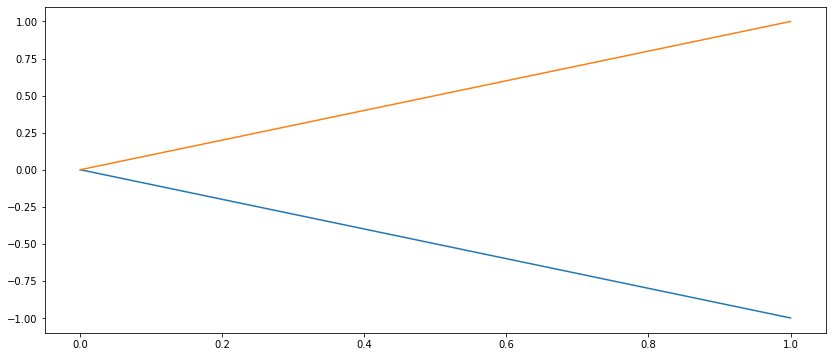

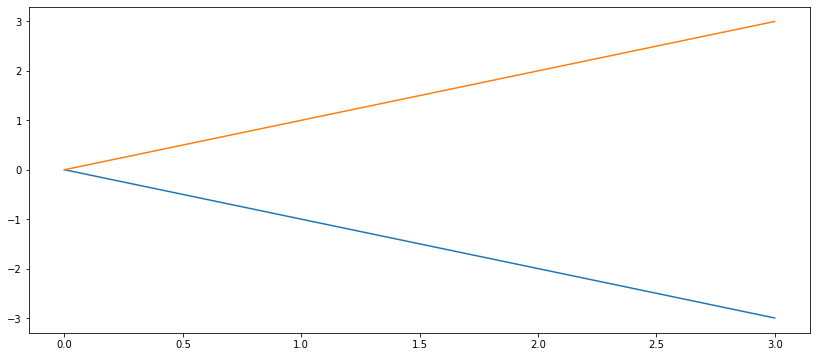

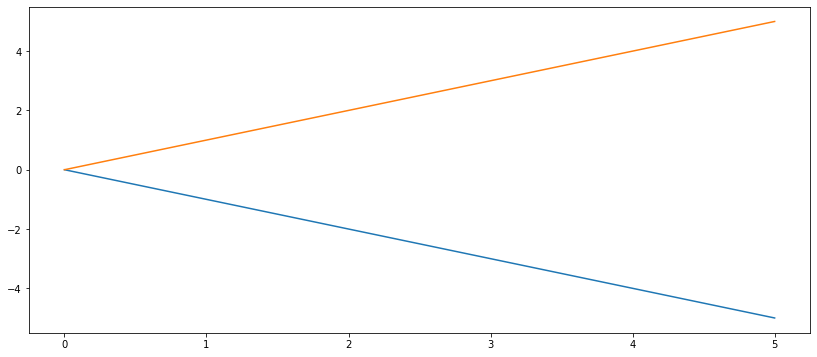

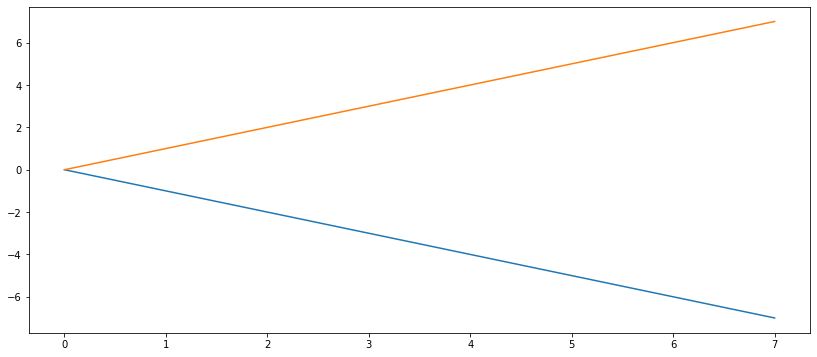

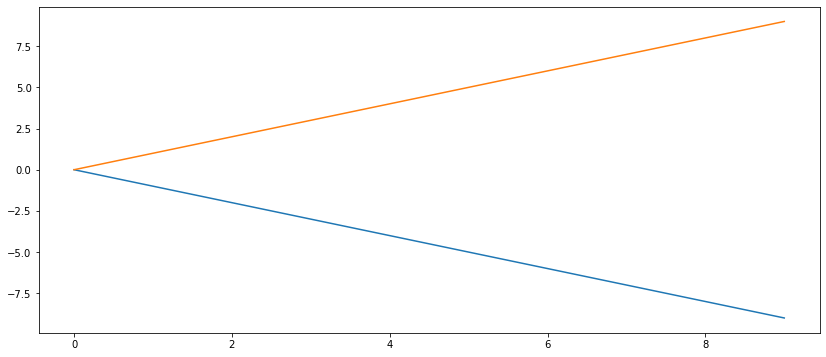

In [41]:
# Demonstracja na przykładzie losowego agenta vs agenta używającego MCTS

class RandomAgent(OpenSpielAgent):
    def __init__(self, game):
        super().__init__(game)
        
    def step(self, state):
        return np.random.choice(state.legal_actions())

    
game = pyspiel.load_game("connect_four")
random_agent = RandomAgent(game)
mcts_agent = mcts.MCTSBot(game, sqrt(2), 100, mcts.RandomRolloutEvaluator())
rewards = play_game(game, (random_agent, mcts_agent), 10, plot=True, plot_interval=2)

## Zad 2 - Monte Carlo Tree Search (20pkt)

W komórkach poniżej zaimplementuj Agenta używającego Monte Carlo Tree Search dla środowiska `Connect Four`. Użyj losowej polityki rolloutu oraz polityki drzewa opartej o UCB. 

Odpowiedź na pytania:
- Ile stanów posiada środowisko `Connect Four` (ile wierzchołków ma drzewo stanów, możesz policzyć za pomocą komutera).
- Czy widzisz jakiś sprytny sposób na mniejszenie przestrzeni stanów dla gry `Connect Four`? (nie implemnetuj jej).

Uwagi:
- Zadbaj o to by wybór ruch przez Twojego agenta nie trwał dłużej niż 1-2 sekundy.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Agent powinen wygrywać albo remisować większość gier, które rozpoczyna przeciwko innemu silnemu graczowi (np. gotowemu botowi MCTS).

#### Uwaga: nie zmieniaj nazwy klasy `MCTSAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

1) Obliczenie liczby stanów dla gry Connect Four, jest niemożliwe korzystając z możliwości obliczeniowych komputerów osobistych. Im więcej rozstawionych żetonów tym drzewo jest coraz głębsze, a liczba stanów rośnie w sposób wykładniczy zależny od głebokości drzewa. Zakładając, że wszystkie pola są zajęte przez żetony liczba możliwych ustawień żetonów wyniosłaby dwumian newtona 42 po 21 co jest bardzo dużą liczbą. Ponadto należałoby uwzględnić wszystkie stany pośrednie, których też z pewnością jest bardzo dużo. Oczywiście, część stanów musiałaby zostać odjęta od tego wyniku, gdyż byłyby niemożliwe do spełnienia (jak pokrycie dolnej części planszy jednym kolorem a górnej całkowicie drugim kolorem żetonów) lub stany gdzie w międzyczasie doszło do zwycięstwa. Nadal jednak ta liczba musiałaby być bardzo wysoka.

Według Wikipedii liczba stanów wynosi 4,531,985,219,092.


2) Ograniczenie liczby stanów może być możliwe dzięki wykorzystaniu wiedzy eksperckiej o strategiach wykorzystywanych w grze i wykorzystywanie jej. W początkowej fazie rozgrywki można istotnie zmniejszyć liczbę rozpatrywanych poddrzew poprzez analizę tylko tych ruchów, które prowadzą do umieszczenia żetonu w centralnej części planszy. Umieszczenie takie daje znacznie większą kontrolę nad planszą oraz więcej opcji połaczenia żetonów w 4, ponieważ można dokładać żetony z obu stron. Ponadto przez to, że plansza ma szerokość 7 na pewno jakiś żeton będzie musiał być ustawiony w centrum (o ile nie ustawiamy żetonów w kolumnie) przez co naturalnie będą to preferowane przez graczy ruchy. Dodatkowo w momencie gdy przeciwnik ma 2 żetony pod rząd, rozpatrywanie wszystkich możliwości może być zbędne i warto sprawdzić jedynie ruchy blokujące dalszy rozwój tego ciągu. Podobnie, prawdopodobnie można postąpić z innymi tego rodzaju schematami rozstawienia żetonów przeciwnika.

In [42]:
import math
import sys
from time import perf_counter

class Node:
  def __init__(self, state, my_player, parent=None):
    self.state = state
    self.my_player = my_player
    self.current_player = state.current_player()
    self.parent = parent
    self.children = []
    self.total_score = 0
    self.num_of_visits = 0

  def is_leaf(self):
    return len(self.children) == 0

  def ucb_score(self):
    return self.total_score / self.num_of_visits + (2 * math.log(self.parent.num_of_visits) / self.num_of_visits) ** 0.5

  def expand(self):
    for action in self.state.legal_actions():
      state = self.state.clone()
      state.apply_action(action)
      self.children.append(Node(state, self.my_player, parent=self))

  def tree_policy(self):
    max_ucb = None
    best_action = None
    for action, child in enumerate(self.children):
      if child.num_of_visits == 0:
        return action
      if max_ucb is None:
        max_ucb = child.ucb_score()
        best_action = action
      else:
        if max_ucb < child.ucb_score():
          max_ucb = child.ucb_score()
          best_action = action
    
    return best_action

  def select_best_action(self):
    max_visits = None
    best_action = None
    for action, child in enumerate(self.children):
      if max_visits is None:
        max_visits = child.num_of_visits
        best_action = action
      else:
        if max_visits < child.num_of_visits:
          max_visits = child.num_of_visits
          best_action = action

    return best_action

  def backpropagate(self, reward):
    if self.current_player != self.my_player:
      self.total_score += max(reward, 0)
    else:
      self.total_score += abs(min(reward, 0))
    self.num_of_visits += 1
    
    if self.parent is not None:
      self.parent.backpropagate(reward)

  def rollout(self):
    state = self.state.clone()
    while not state.is_terminal():
      action = np.random.choice(state.legal_actions())
      state.apply_action(action)
    reward = state.player_reward(self.my_player)

    return reward

In [43]:
def selection(root_node):
  current_node = root_node
  while not current_node.is_leaf():
    action = current_node.tree_policy()
    current_node = current_node.children[action]

  return current_node

def monte_carlo_tree_search(state, time_limit):
  my_player = state.current_player()
  root_node = Node(state, my_player)
  time_start = perf_counter() 
  while perf_counter() - time_start < time_limit:
    node = selection(root_node)
    node.expand()
    if not node.state.is_terminal():
      node = node.children[node.tree_policy()]
    reward = node.rollout()
    node.backpropagate(reward)
  return root_node

In [44]:
class MCTSAgent(OpenSpielAgent):
    def __init__(self, game, time_limit):
        super().__init__(game)
        self.time_limit = time_limit
    
    def step(self, state):
      root_node = monte_carlo_tree_search(state, self.time_limit)
      action = root_node.select_best_action()
      return root_node.state.legal_actions()[action]


[[0,
  1.0,
  2.0,
  3.0,
  2.0,
  1.0,
  2.0,
  1.0,
  2.0,
  3.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  6.0,
  7.0,
  8.0,
  9.0,
  9.0,
  8.0,
  7.0,
  8.0,
  9.0,
  10.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  14.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  17.0,
  18.0,
  17.0,
  18.0,
  19.0,
  20.0,
  19.0,
  20.0,
  21.0,
  22.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  27.0,
  28.0,
  27.0,
  28.0,
  29.0,
  30.0,
  31.0,
  32.0,
  31.0,
  32.0,
  31.0,
  30.0,
  31.0,
  32.0,
  33.0,
  34.0,
  33.0,
  34.0,
  35.0,
  36.0,
  35.0,
  34.0,
  35.0,
  36.0,
  35.0,
  36.0,
  37.0,
  38.0,
  39.0,
  40.0,
  39.0,
  40.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  44.0,
  45.0,
  46.0,
  47.0,
  48.0,
  49.0],
 [0,
  -1.0,
  -2.0,
  -3.0,
  -2.0,
  -1.0,
  -2.0,
  -1.0,
  -2.0,
  -3.0,
  -2.0,
  -3.0,
  -4.0,
  -5.0,
  -6.0,
  -7.0,
  -6.0,
  -7.0,
  -8.0,
  -9.0,
  -9.0,
  -8.0,
  -7.0,
  -8.0,
  -9.0,
  -10.0,
  -9.0,
  -10

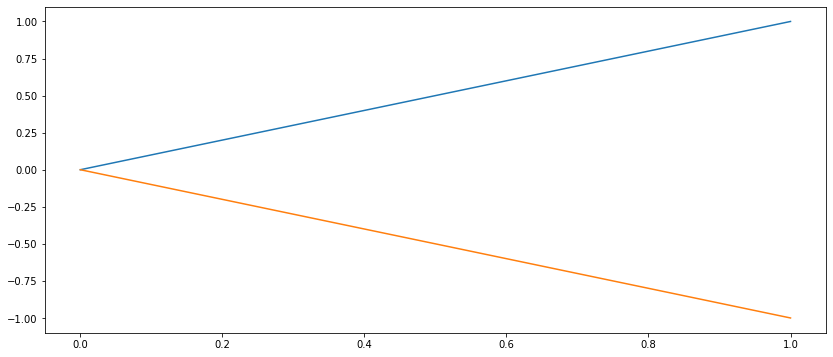

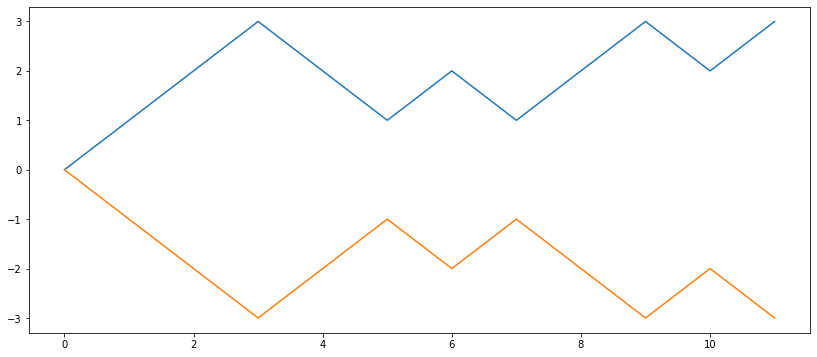

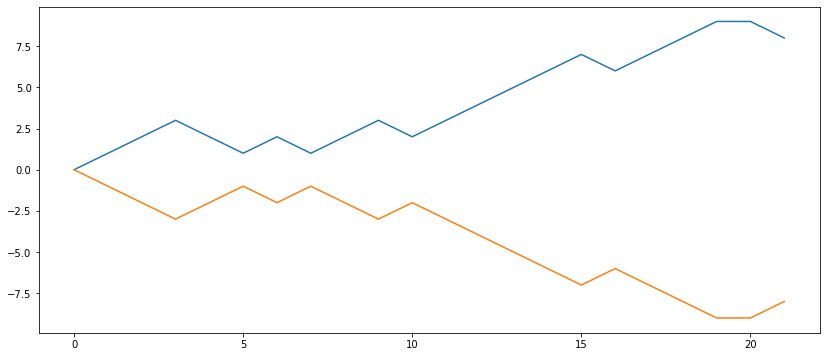

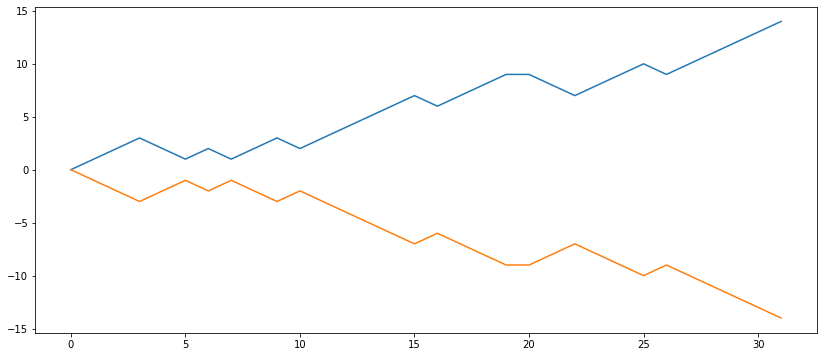

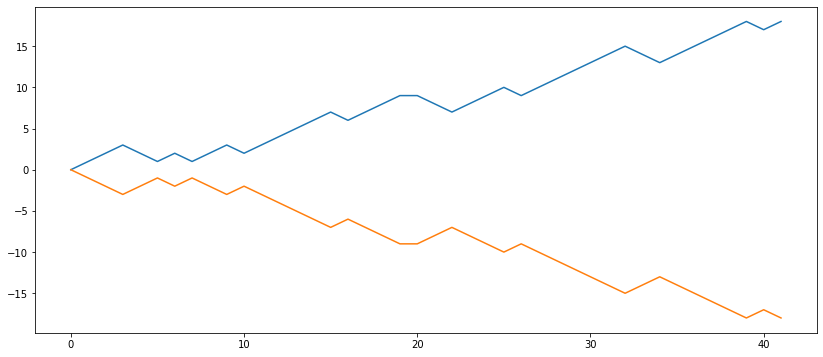

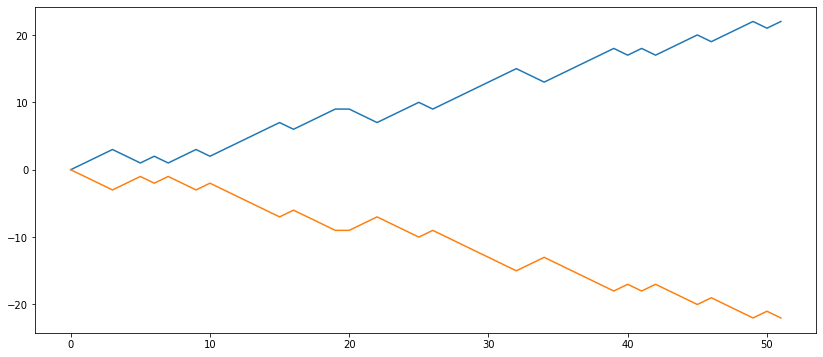

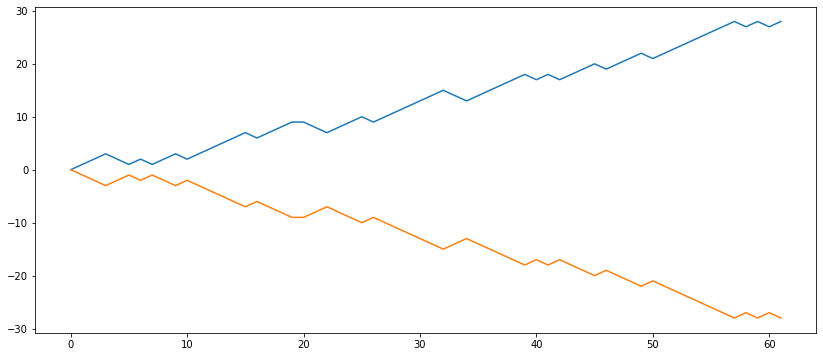

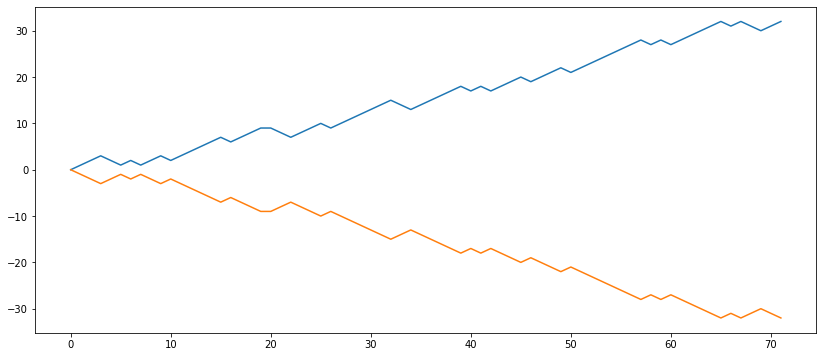

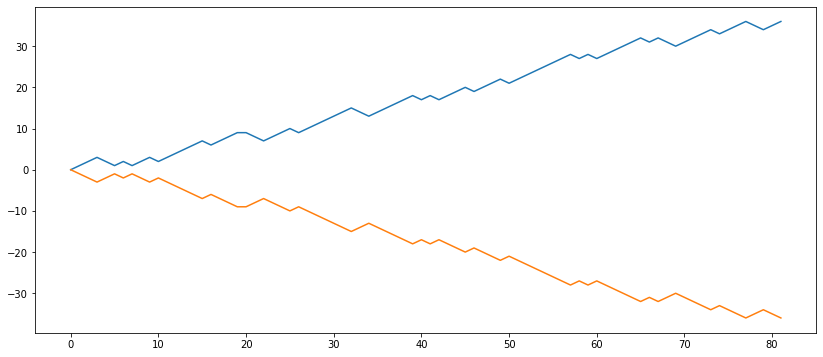

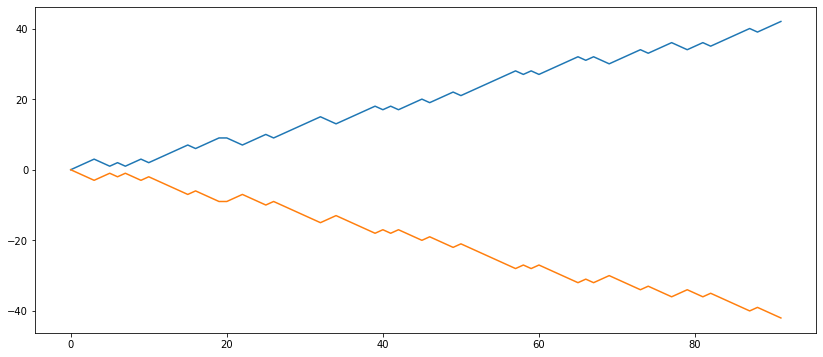

In [45]:
# Testowania agenta
game = pyspiel.load_game("connect_four")
agent = MCTSAgent(game, 1.9)
mcts_agent = mcts.MCTSBot(game, sqrt(2), 100, mcts.RandomRolloutEvaluator())
play_game(game, (agent, mcts_agent), 100, plot=True, plot_interval=10)